In [1]:
import os
import warnings

os.environ["TOKENIZERS_PARALLELISM"] = "false"
print("✓ TOKENIZERS_PARALLELISM configurado a 'false' para evitar warnings")

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning, module="transformers")

print("✓ Configuración de warnings completada")

✓ TOKENIZERS_PARALLELISM configurado a 'false' para evitar warnings
✓ Configuración de warnings completada


# Modelado de Tópicos con BERTopic

Este notebook implementa un análisis de tópicos usando BERTopic sobre las opiniones turísticas clasificadas. Utiliza LangChain con GPT-4o-mini para asignar nombres semánticamente coherentes a los tópicos identificados.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
import os
import sys
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import PydanticOutputParser
from langchain_core.prompts import PromptTemplate
from pydantic import BaseModel, Field
from typing import Literal
import nltk

sys.path.append('../scripts')

from topicos import (
    LimpiadorTextoMejorado, 
    generar_reporte_limpieza, 
    mostrar_ejemplos_limpieza,
    evaluar_modelo_topicos,
    extraer_palabras_bertopic,
    mostrar_metricas
)

load_dotenv()

nltk.download('punkt_tab')
nltk.download("stopwords")

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

✓ Modelo spaCy español cargado
✓ Modelo spaCy inglés cargado
✓ Modelo spaCy portugués cargado
✓ Modelo spaCy francés cargado
✓ Modelo spaCy italiano cargado
Descargando wordnet...


[nltk_data] Downloading package wordnet to
[nltk_data]     /home/victorwkey/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/victorwkey/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/victorwkey/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
from topicos import configurar_clasificador_topicos, configurar_bertopic_inteligente

clasificador_topicos = configurar_clasificador_topicos()

In [6]:
CIUDAD_ANALIZAR = "Cdmx"
df = pd.read_csv('../data/processed/dataset_opiniones_analisis.csv')

if 'TopicoConBERTopic' not in df.columns:
    df['TopicoConBERTopic'] = np.nan

print(f"Dataset cargado: {df.shape[0]} opiniones")
print(f"Columnas disponibles: {list(df.columns)}")
print(f"\nDistribución total por ciudad:")
print(df['Ciudad'].value_counts())

df_ciudad = df[df['Ciudad'] == CIUDAD_ANALIZAR].copy()

columna_texto = 'TituloReviewLimpio'

texts = df_ciudad[columna_texto].dropna().tolist()

palabras_promedio = sum(len(text.split()) for text in texts) / len(texts)
print(f"📊 Promedio de palabras por texto: {palabras_promedio:.1f}")
print(f"📏 Longitud promedio: {sum(len(text) for text in texts) / len(texts):.1f} caracteres")

Dataset cargado: 2464 opiniones
Columnas disponibles: ['Titulo', 'Review', 'Calificacion', 'FechaEstadia', 'Ciudad', 'Atraccion', 'TituloReview', 'TituloReviewLimpio', 'SentimientoPorCalificacion', 'SentimientoPorHF', 'SentimientoPorCardiff', 'SubjetividadConHF', 'SubjetividadConFrases', 'SubjetividadConLLM', 'TopicoConBERTopic']

Distribución total por ciudad:
Ciudad
Mazatlan           500
Puebla             500
Puerto_vallarta    491
Cdmx               490
Cancun             483
Name: count, dtype: int64
📊 Promedio de palabras por texto: 60.4
📏 Longitud promedio: 340.1 caracteres


In [7]:
from numpy import False_


limpiar_de_nuevo = True

columna_limpia = "TituloReviewLimpio"

if columna_texto not in df_ciudad.columns or df_ciudad[columna_texto].isna().all() or limpiar_de_nuevo:

    limpiador = LimpiadorTextoMejorado(idiomas=['spanish', 'english'])

    df_antes = df.copy()

    df = limpiador.limpiar_dataframe(
        df,
        columna_texto='TituloReview',
        nombre_columna_limpia=columna_limpia,
        aplicar_lematizacion=False,
        min_longitud_palabra=2,
        max_palabras=None
    )

    mostrar_ejemplos_limpieza(df, n_ejemplos=3)

    generar_reporte_limpieza(df_antes, df, 'TituloReview', columna_limpia)

    df.to_csv('../data/processed/dataset_opiniones_analisis.csv', index=False)

🧹 Limpiando columna 'TituloReview'...
Procesando 2464 textos...
Procesado: 0/2464 textos
Procesado: 100/2464 textos
Procesado: 200/2464 textos
Procesado: 300/2464 textos
Procesado: 400/2464 textos
Procesado: 500/2464 textos
Procesado: 600/2464 textos
Procesado: 700/2464 textos
Procesado: 800/2464 textos
Procesado: 900/2464 textos
Procesado: 1000/2464 textos
Procesado: 1100/2464 textos
Procesado: 1200/2464 textos
Procesado: 1300/2464 textos
Procesado: 1400/2464 textos
Procesado: 1500/2464 textos
Procesado: 1600/2464 textos
Procesado: 1700/2464 textos
Procesado: 1800/2464 textos
Procesado: 1900/2464 textos
Procesado: 2000/2464 textos
Procesado: 2100/2464 textos
Procesado: 2200/2464 textos
Procesado: 2300/2464 textos
Procesado: 2400/2464 textos
✓ Columna 'TituloReviewLimpio' actualizada

📊 Estadísticas de limpieza:
   • Textos procesados: 2464
   • Textos válidos: 2464
   • Textos vacíos: 0
   • Promedio palabras original: 57.2
   • Promedio palabras limpio: 57.4
   • Reducción promedio: 

In [8]:
# ===== CONFIGURACIÓN INTELIGENTE DE BERTOPIC =====
topic_model, reporte_optimizacion = configurar_bertopic_inteligente(texts)
    
print("🤖 Configuración automática de BERTopic completada")
print(reporte_optimizacion)

print("\n🚀 Entrenando modelo con hiperparámetros optimizados...")
topics, probs = topic_model.fit_transform(texts)


🤖 Configuración automática de BERTopic completada
🤖 OPTIMIZACIÓN AUTOMÁTICA DE BERTOPIC

📊 CARACTERÍSTICAS DEL DATASET:
   Número de textos: 490
   Palabras promedio: 60.4
   Diversidad léxica: 0.170
   Homogeneidad: 0.563
   Densidad semántica: 0.426

⚙️ HIPERPARÁMETROS OPTIMIZADOS:
   Embedding: paraphrase-multilingual-MiniLM-L12-v2
   UMAP n_neighbors: 25
   UMAP n_components: 25
   HDBSCAN min_cluster_size: 29
   Vectorizer max_features: 350
   Vectorizer ngram_range: (1, 3)

💡 JUSTIFICACIONES:
   - Baja diversidad: dimensiones reducidas y filtrado más restrictivo

🚀 Entrenando modelo con hiperparámetros optimizados...


In [10]:
topic_info = topic_model.get_topic_info()
print(f"Tópicos identificados: {len(topic_info)} (incluyendo outliers)")

# Preparar información de tópicos para el clasificador LLM
topics_info_str = ""
topic_data = []

for topic_id in topic_info['Topic']:
    if topic_id == -1:
        continue
    
    topic_words = topic_model.get_topic(topic_id)
    keywords = ", ".join([word for word, _ in topic_words[:8]])
    count = topic_info[topic_info['Topic'] == topic_id]['Count'].iloc[0]
    
    topic_data.append({
        'id': topic_id,
        'keywords': keywords,
        'count': count
    })
    
    topics_info_str += f"Tópico {topic_id}: {keywords} (documentos: {count})\n"

print(f"\nPalabras clave por tópico:")
print(topics_info_str)

# Usar el clasificador LLM para asignar etiquetas
if topic_data:  # Solo si hay tópicos válidos
    resultado = clasificador_topicos.invoke({"topics_info": topics_info_str})
    
    # Crear mapeo de nombres de tópicos
    topic_names = {}
    topic_names[-1] = "Opiniones Diversas"  # Para outliers
    
    # Mapear resultados del LLM
    for topic_label in resultado.topics:
        topic_names[topic_label.topic_id] = topic_label.label
        print(f"Tópico {topic_label.topic_id}: {topic_label.label}")
    
    # Asignar las etiquetas al modelo BERTopic
    topic_model.set_topic_labels(topic_names)
    
else:
    # Fallback si no hay tópicos válidos
    topic_names = {-1: "Opiniones Diversas"}
    print("⚠️ No se encontraron tópicos válidos para etiquetar")

Tópicos identificados: 5 (incluyendo outliers)

Palabras clave por tópico:
Tópico 0: mexico, ciudad, museum, ciudad mexico, museo, arte, city, history (documentos: 110)
Tópico 1: museo, museum, arte, coleccion, historia, obras, exposicion, tan (documentos: 68)
Tópico 2: animales, acuario, personal, grupos, actividades, ninos, gusto, parece (documentos: 60)
Tópico 3: basilica, guadalupe, virgen, mass, tour, hill, misa, iglesia (documentos: 43)

Tópico 0: Patrimonio Cultural
Tópico 1: Museos
Tópico 2: Vida Marina
Tópico 3: Sitios Religiosos
Tópico 0: Patrimonio Cultural
Tópico 1: Museos
Tópico 2: Vida Marina
Tópico 3: Sitios Religiosos


In [11]:
# Procesar solo datos de la ciudad seleccionada
df_con_topicos = df_ciudad.dropna(subset=[columna_texto]).copy()
df_con_topicos['Topico'] = topics
df_con_topicos['Topico_Nombre'] = df_con_topicos['Topico'].map(topic_names)
df_con_topicos['Probabilidad_Topico'] = probs.max(axis=1)

# Verificar si la ciudad ya tenía resultados previos
indices_ciudad = df_con_topicos.index
opiniones_previas = df.loc[indices_ciudad, 'TopicoConBERTopic'].notna().sum()

if opiniones_previas > 0:
    print(f"🔄 SOBRESCRIBIENDO resultados previos para {CIUDAD_ANALIZAR}:")
    print(f"   📝 Opiniones con tópicos previos: {opiniones_previas}")
    print(f"   🆕 Nuevas asignaciones de tópicos: {len(df_con_topicos)}")
else:
    print(f"🆕 PRIMERA VEZ procesando {CIUDAD_ANALIZAR}:")
    print(f"   📝 Nuevas asignaciones de tópicos: {len(df_con_topicos)}")

# Actualizar el dataset original con los tópicos de la ciudad analizada
df.loc[indices_ciudad, 'TopicoConBERTopic'] = df_con_topicos['Topico_Nombre']

print(f"\n✅ Actualización completada para {CIUDAD_ANALIZAR}")
print(f"Distribución de tópicos en {CIUDAD_ANALIZAR}:")
topico_counts = df_con_topicos['Topico_Nombre'].value_counts()
print(topico_counts)

print(f"\nPorcentaje de opiniones por tópico en {CIUDAD_ANALIZAR}:")
topico_pct = (topico_counts / len(df_con_topicos) * 100).round(2)
for topico, pct in topico_pct.items():
    print(f"{topico}: {pct}%")

print(f"\nEstado actualización dataset completo:")
print(f"Total opiniones: {len(df)}")
print(f"Opiniones con tópico asignado: {df['TopicoConBERTopic'].notna().sum()}")
print(f"Opiniones pendientes: {df['TopicoConBERTopic'].isna().sum()}")

# Mostrar calidad de la limpieza aplicada
if columna_texto == 'TituloReviewLimpio':
    textos_vacios = df_con_topicos[columna_texto].str.strip().eq('').sum()
    print(f"\n🧹 Calidad de limpieza en {CIUDAD_ANALIZAR}:")
    print(f"Textos vacíos tras limpieza: {textos_vacios}")
    print(f"Textos válidos para análisis: {len(df_con_topicos) - textos_vacios}")
    
    # Comparar longitud promedio original vs limpia
    if 'TituloReview' in df_con_topicos.columns:
        len_original = df_con_topicos['TituloReview'].str.len().mean()
        len_limpia = df_con_topicos['TituloReviewLimpio'].str.len().mean()
        reduccion = ((len_original - len_limpia) / len_original * 100)
        print(f"Reducción promedio de texto: {reduccion:.1f}%")

🆕 PRIMERA VEZ procesando Cdmx:
   📝 Nuevas asignaciones de tópicos: 490

✅ Actualización completada para Cdmx
Distribución de tópicos en Cdmx:
Topico_Nombre
Opiniones Diversas     209
Patrimonio Cultural    110
Museos                  68
Vida Marina             60
Sitios Religiosos       43
Name: count, dtype: int64

Porcentaje de opiniones por tópico en Cdmx:
Opiniones Diversas: 42.65%
Patrimonio Cultural: 22.45%
Museos: 13.88%
Vida Marina: 12.24%
Sitios Religiosos: 8.78%

Estado actualización dataset completo:
Total opiniones: 2464
Opiniones con tópico asignado: 490
Opiniones pendientes: 1974

🧹 Calidad de limpieza en Cdmx:
Textos vacíos tras limpieza: 0
Textos válidos para análisis: 490
Reducción promedio de texto: 2.5%


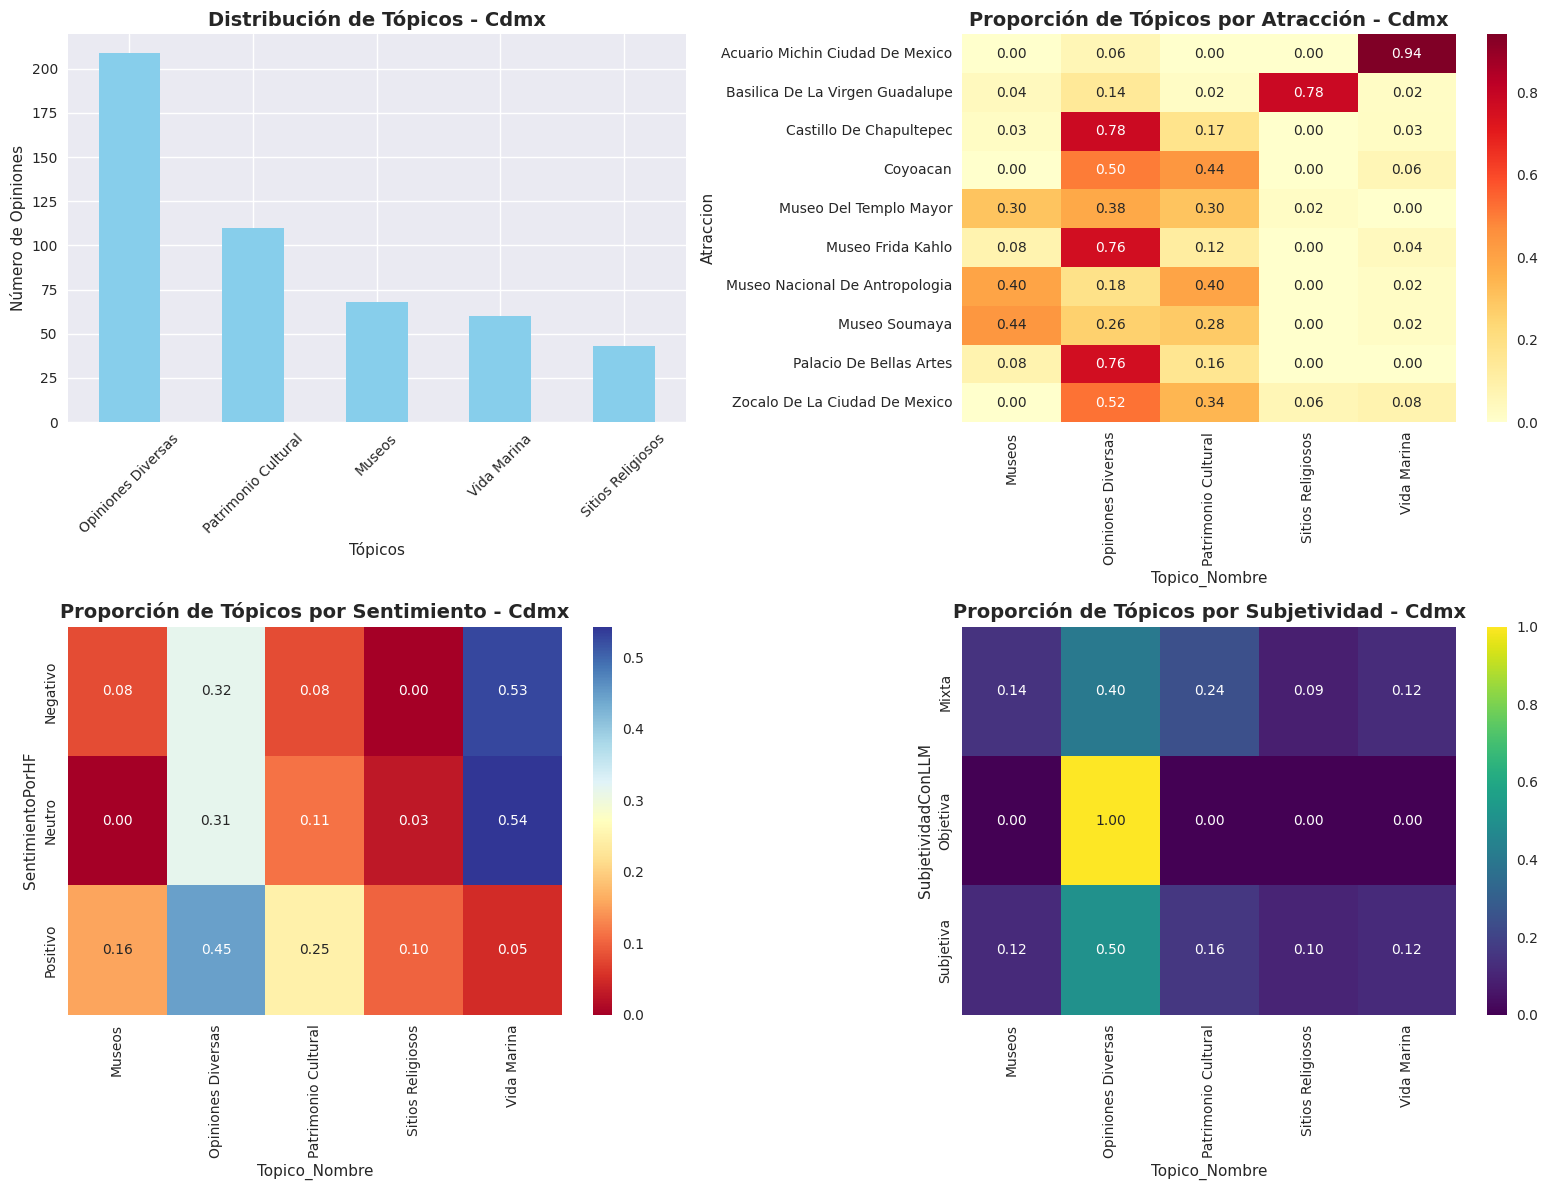

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Gráfico 1: Distribución de tópicos en la ciudad
topico_counts.plot(kind='bar', ax=axes[0,0], color='skyblue')
axes[0,0].set_title(f'Distribución de Tópicos - {CIUDAD_ANALIZAR}', fontsize=14, fontweight='bold')
axes[0,0].set_xlabel('Tópicos')
axes[0,0].set_ylabel('Número de Opiniones')
axes[0,0].tick_params(axis='x', rotation=45)

# Gráfico 2: Distribución por atracción en la ciudad
if len(df_con_topicos['Atraccion'].unique()) > 1:
    atraccion_topico = pd.crosstab(df_con_topicos['Atraccion'], df_con_topicos['Topico_Nombre'])
    atraccion_topico_norm = atraccion_topico.div(atraccion_topico.sum(axis=1), axis=0)
    sns.heatmap(atraccion_topico_norm, annot=True, fmt='.2f', ax=axes[0,1], cmap='YlOrRd')
    axes[0,1].set_title(f'Proporción de Tópicos por Atracción - {CIUDAD_ANALIZAR}', fontsize=14, fontweight='bold')
else:
    axes[0,1].text(0.5, 0.5, f'Solo una atracción en {CIUDAD_ANALIZAR}', ha='center', va='center', transform=axes[0,1].transAxes)
    axes[0,1].set_title(f'Distribución por Atracción - {CIUDAD_ANALIZAR}', fontsize=14, fontweight='bold')

# Gráfico 3: Tópicos por sentimiento
sentimiento_topico = pd.crosstab(df_con_topicos['SentimientoPorHF'], df_con_topicos['Topico_Nombre'])
sentimiento_topico_norm = sentimiento_topico.div(sentimiento_topico.sum(axis=1), axis=0)
sns.heatmap(sentimiento_topico_norm, annot=True, fmt='.2f', ax=axes[1,0], cmap='RdYlBu')
axes[1,0].set_title(f'Proporción de Tópicos por Sentimiento - {CIUDAD_ANALIZAR}', fontsize=14, fontweight='bold')

# Gráfico 4: Tópicos por subjetividad
subjetividad_topico = pd.crosstab(df_con_topicos['SubjetividadConLLM'], df_con_topicos['Topico_Nombre'])
subjetividad_topico_norm = subjetividad_topico.div(subjetividad_topico.sum(axis=1), axis=0)
sns.heatmap(subjetividad_topico_norm, annot=True, fmt='.2f', ax=axes[1,1], cmap='viridis')
axes[1,1].set_title(f'Proporción de Tópicos por Subjetividad - {CIUDAD_ANALIZAR}', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

In [13]:
print(f"Ejemplos de opiniones por tópico en {CIUDAD_ANALIZAR}:")
print("=" * 60)

for topico_nombre in topico_counts.index[:5]:
    ejemplos = df_con_topicos[df_con_topicos['Topico_Nombre'] == topico_nombre]['TituloReview'].head(3)
    print(f"\n🏷️ Tópico: {topico_nombre}")
    print(f"📊 Total de opiniones: {topico_counts[topico_nombre]}")
    print("📝 Ejemplos:")
    for i, ejemplo in enumerate(ejemplos, 1):
        print(f"  {i}. {ejemplo[:100]}{'...' if len(ejemplo) > 100 else ''}")
    print("-" * 50)

Ejemplos de opiniones por tópico en Cdmx:

🏷️ Tópico: Opiniones Diversas
📊 Total de opiniones: 209
📝 Ejemplos:
  1. 10 de 10. Simplemente espectacular! No se lo pierdan el ballet folklórico. Tienen mucho talento esos...
  2. Mexican muralism at its finest!. It was an outstanding example of Mexican muralism. A do not miss ac...
  3. Ballet Folklórico de México de Amalia Hernández. excelente producción, que te llena los sentidos y t...
--------------------------------------------------

🏷️ Tópico: Patrimonio Cultural
📊 Total de opiniones: 110
📝 Ejemplos:
  1. Amazing architecture. Gorgeous architecture with a beautiful nearby park! Also, plenty of street ven...
  2. Hermoso. Se ve hermoso de noche, y ese parque es una fiesta en cada esquina, sonideros y al gente ba...
  3. Sitio histórico. Es un lugar lleno de historia, tanto en las afueras como en su interior. Los doming...
--------------------------------------------------

🏷️ Tópico: Museos
📊 Total de opiniones: 68
📝 Ejemplos:
  1. Lo

🔍 Comparación de ejemplos - Original vs Limpio (Cdmx):

📄 EJEMPLO 1 - Tópico: Opiniones Diversas
🔸 Original: Be sure to visit when in Mexico City. Visiting the Frida Kahlo museum is a definite "must do" when visiting Mexico City. The house and compound themselves are breathtakingly beautiful. The content of the house is fascinating and so very interesting - an homage to an extraordinary woman and artist. Be sure to buy tickets in advance.
🔹 Limpio:   be sure to visit when in mexico city visiting the frida kahlo museum is a definite must do when visiting mexico city the house and compound themselves are breathtakingly beautiful the content of the house is fascinating and so very interesting an homage to an extraordinary woman and artist be sure to buy tickets in advance
📊 Caracteres: 333 → 324 (2.7% reducción)
📝 Palabras: 57 → 56 (1.8% reducción)
--------------------------------------------------------------------------------

📄 EJEMPLO 2 - Tópico: Opiniones Diversas
🔸 Original: Un refu

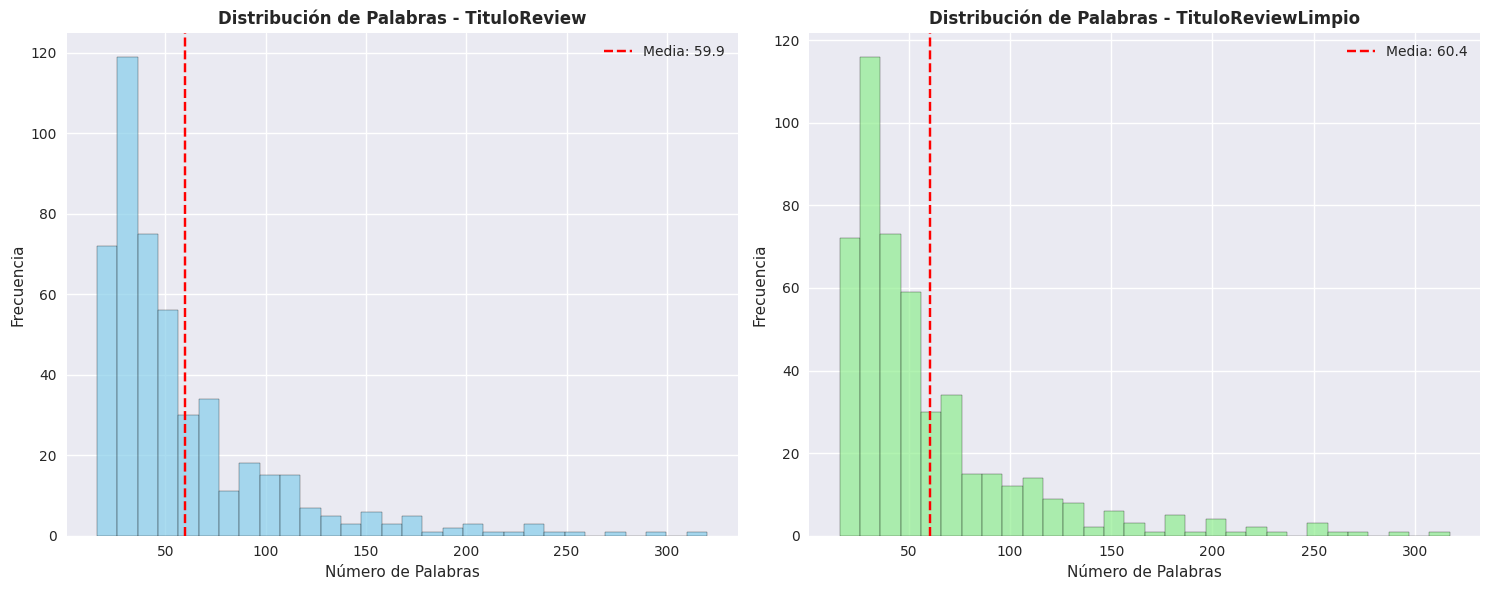

📊 ESTADÍSTICAS DE DISTRIBUCIÓN DE PALABRAS:
Original - Media: 59.9, Mediana: 43.0
Limpio   - Media: 60.4, Mediana: 43.0


In [14]:
# ===== COMPARACIÓN TEXTO ORIGINAL VS TEXTO LIMPIO =====

if 'TituloReviewLimpio' in df_con_topicos.columns:
    print(f"🔍 Comparación de ejemplos - Original vs Limpio ({CIUDAD_ANALIZAR}):")
    print("=" * 80)
    
    # Seleccionar algunos ejemplos para mostrar la diferencia
    ejemplos_muestra = df_con_topicos.sample(n=min(15, len(df_con_topicos)))
    
    for i, (_, row) in enumerate(ejemplos_muestra.iterrows(), 1):
        print(f"\n📄 EJEMPLO {i} - Tópico: {row['Topico_Nombre']}")
        print(f"🔸 Original: {row['TituloReview']}")
        print(f"🔹 Limpio:   {row['TituloReviewLimpio']}")
        
        # Calcular estadísticas del ejemplo
        len_orig = len(str(row['TituloReview']))
        len_limpio = len(str(row['TituloReviewLimpio']))
        palabras_orig = len(str(row['TituloReview']).split())
        palabras_limpio = len(str(row['TituloReviewLimpio']).split())
        
        print(f"📊 Caracteres: {len_orig} → {len_limpio} ({((len_orig-len_limpio)/len_orig*100):.1f}% reducción)")
        print(f"📝 Palabras: {palabras_orig} → {palabras_limpio} ({((palabras_orig-palabras_limpio)/palabras_orig*100):.1f}% reducción)")
        print("-" * 80)
    
    # Estadísticas generales de limpieza
    from topicos.utils_topicos import visualizar_distribucion_palabras, mostrar_estadisticas_limpieza
    
    print(f"\n📈 ESTADÍSTICAS GENERALES DE LIMPIEZA - {CIUDAD_ANALIZAR}")
    mostrar_estadisticas_limpieza(df_con_topicos, 'TituloReview', 'TituloReviewLimpio')
    
    # Visualización de distribución de palabras
    visualizar_distribucion_palabras(df_con_topicos, 'TituloReview', 'TituloReviewLimpio')

In [15]:
# ===== VISUALIZACIONES INTERACTIVAS DE BERTOPIC =====

print(f"Visualizaciones interactivas de BERTopic para {CIUDAD_ANALIZAR}:")
print(f"Tópicos identificados: {len(topic_info)} (incluyendo outliers si los hay)")

# Validar si tenemos suficientes tópicos para visualizaciones
num_topicos_validos = len([t for t in topic_info['Topic'] if t != -1])
print(f"Tópicos válidos (sin outliers): {num_topicos_validos}")

if num_topicos_validos < 2:
    print("⚠️ ADVERTENCIA: Muy pocos tópicos identificados para generar visualizaciones interactivas.")
    print("💡 Esto puede deberse a:")
    print("   - Textos muy similares después de la limpieza")
    print("   - Dataset pequeño para la ciudad seleccionada")
    print("   - Parámetros de clustering muy restrictivos")
    print("\n📊 Mostrando información básica de tópicos:")
    for topic_id in topic_info['Topic']:
        if topic_id != -1:
            topic_words = topic_model.get_topic(topic_id)
            print(f"\nTópico {topic_id}: {topic_names.get(topic_id, 'Sin nombre')}")
            print(f"Palabras clave: {', '.join([word for word, _ in topic_words[:8]])}")
            print(f"Documentos: {topic_info[topic_info['Topic'] == topic_id]['Count'].iloc[0]}")
else:
    # Intentar generar visualizaciones con manejo de errores
    try:
        print("\n🗺️ Generando mapa de tópicos...")
        fig_intertopic = topic_model.visualize_topics()
        fig_intertopic.update_layout(title=f"Mapa de Tópicos - {CIUDAD_ANALIZAR}")
        fig_intertopic.show()
    except Exception as e:
        print(f"❌ Error al generar mapa de tópicos: {str(e)}")
        print("💡 Esto es normal con pocos tópicos o datos limitados")

    try:
        print("\n📊 Generando gráfico de barras...")
        fig_barchart = topic_model.visualize_barchart(top_n_topics=min(8, num_topicos_validos))
        fig_barchart.update_layout(title=f"Palabras Clave por Tópico - {CIUDAD_ANALIZAR}")
        fig_barchart.show()
    except Exception as e:
        print(f"❌ Error al generar gráfico de barras: {str(e)}")
        print("🔧 Mostrando información alternativa de palabras clave:")
        for topic_id in topic_info['Topic'][:5]:  # Mostrar máximo 5 tópicos
            if topic_id != -1:
                topic_words = topic_model.get_topic(topic_id)
                print(f"\n📈 {topic_names.get(topic_id, f'Tópico {topic_id}')}:")
                print(f"   {', '.join([f'{word}({score:.3f})' for word, score in topic_words[:5]])}")

    try:
        print("\n🌳 Generando jerarquía de tópicos...")
        if num_topicos_validos >= 3:  # Necesitamos al menos 3 tópicos para jerarquía
            fig_hierarchy = topic_model.visualize_hierarchy()
            fig_hierarchy.update_layout(title=f"Jerarquía de Tópicos - {CIUDAD_ANALIZAR}")
            fig_hierarchy.show()
        else:
            print("⚠️ Se necesitan al menos 3 tópicos para mostrar jerarquía")
    except Exception as e:
        print(f"❌ Error al generar jerarquía: {str(e)}")

# Información adicional sobre la calidad del modelado
print(f"\n📋 Resumen del modelado:")
print(f"✅ Textos analizados: {len(texts)}")
print(f"🎯 Tópicos encontrados: {num_topicos_validos}")
print(f"📊 Distribución:")
for i, (topico, count) in enumerate(topico_counts.head(5).items()):
    print(f"   {i+1}. {topico}: {count} opiniones ({count/len(df_con_topicos)*100:.1f}%)")

if num_topicos_validos <= 3:
    print(f"\n💡 Sugerencias para mejorar el modelado:")
    print(f"   - Reducir min_cluster_size en HDBSCAN (actualmente: {hdbscan_model.min_cluster_size})")
    print(f"   - Incluir más ciudades en el análisis")
    print(f"   - Ajustar parámetros de limpieza de texto")
    print(f"   - Verificar diversidad en los textos de entrada")

Visualizaciones interactivas de BERTopic para Cdmx:
Tópicos identificados: 5 (incluyendo outliers si los hay)
Tópicos válidos (sin outliers): 4

🗺️ Generando mapa de tópicos...



📊 Generando gráfico de barras...



🌳 Generando jerarquía de tópicos...



📋 Resumen del modelado:
✅ Textos analizados: 490
🎯 Tópicos encontrados: 4
📊 Distribución:
   1. Opiniones Diversas: 209 opiniones (42.7%)
   2. Patrimonio Cultural: 110 opiniones (22.4%)
   3. Museos: 68 opiniones (13.9%)
   4. Vida Marina: 60 opiniones (12.2%)
   5. Sitios Religiosos: 43 opiniones (8.8%)


In [16]:
# Guardar dataset original con la nueva columna TopicoConBERTopic
print("💾 Guardando dataset actualizado...")
df.to_csv('../data/processed/dataset_opiniones_analisis.csv', index=False)

print("✅ Dataset actualizado y guardado:")
print(f"📁 Archivo: ../data/processed/dataset_opiniones_analisis.csv")
print(f"📊 Total opiniones: {len(df)}")
print(f"🎯 Ciudad analizada: {CIUDAD_ANALIZAR}")
print(f"✅ Opiniones con tópico: {df['TopicoConBERTopic'].notna().sum()}")
print(f"⏳ Opiniones pendientes: {df['TopicoConBERTopic'].isna().sum()}")

print(f"\n📈 Estadísticas de {CIUDAD_ANALIZAR}:")
print(f"Tópicos identificados: {len(topico_counts)}")
print(f"Opiniones analizadas: {len(df_con_topicos)}")
print(f"Probabilidad promedio: {df_con_topicos['Probabilidad_Topico'].mean():.3f}")

# Información sobre limpieza de texto
if 'TituloReviewLimpio' in df.columns:
    print(f"\n🧹 Información de limpieza de texto:")
    print(f"📝 Columna de texto limpio: TituloReviewLimpio")
    print(f"🔧 Método utilizado: {columna_texto}")
    textos_limpios_total = df['TituloReviewLimpio'].notna().sum()
    print(f"✅ Textos limpios disponibles: {textos_limpios_total}")
    
    if textos_limpios_total > 0:
        # Calcular estadísticas de mejora
        palabras_promedio_limpio = df['TituloReviewLimpio'].dropna().str.split().str.len().mean()
        print(f"📊 Promedio palabras (texto limpio): {palabras_promedio_limpio:.1f}")

print(f"\n🔄 Para analizar otra ciudad:")
print(f"1. Cambia la variable CIUDAD_ANALIZAR en la celda correspondiente")
print(f"2. Ejecuta nuevamente las celdas de análisis")
print(f"📍 Ciudades disponibles: {list(df['Ciudad'].unique())}")
print(f"⚠️ IMPORTANTE: Los resultados previos se SOBRESCRIBEN automáticamente")

print(f"\n💡 Mejoras implementadas:")
print(f"✅ Limpieza profunda de texto con spaCy")
print(f"✅ Lematización adecuada para español")
print(f"✅ Eliminación de stopwords en español e inglés")
print(f"✅ Eliminación de emojis, URLs y caracteres especiales")
print(f"✅ Nueva columna TituloReviewLimpio agregada al dataset")
print(f"✅ Sobrescritura automática de resultados para ciudades repetidas")

💾 Guardando dataset actualizado...
✅ Dataset actualizado y guardado:
📁 Archivo: ../data/processed/dataset_opiniones_analisis.csv
📊 Total opiniones: 2464
🎯 Ciudad analizada: Cdmx
✅ Opiniones con tópico: 490
⏳ Opiniones pendientes: 1974

📈 Estadísticas de Cdmx:
Tópicos identificados: 5
Opiniones analizadas: 490
Probabilidad promedio: 0.535

🧹 Información de limpieza de texto:
📝 Columna de texto limpio: TituloReviewLimpio
🔧 Método utilizado: TituloReviewLimpio
✅ Textos limpios disponibles: 2464
📊 Promedio palabras (texto limpio): 57.4

🔄 Para analizar otra ciudad:
1. Cambia la variable CIUDAD_ANALIZAR en la celda correspondiente
2. Ejecuta nuevamente las celdas de análisis
📍 Ciudades disponibles: ['Mazatlan', 'Cancun', 'Puebla', 'Puerto_vallarta', 'Cdmx']
⚠️ IMPORTANTE: Los resultados previos se SOBRESCRIBEN automáticamente

💡 Mejoras implementadas:
✅ Limpieza profunda de texto con spaCy
✅ Lematización adecuada para español
✅ Eliminación de stopwords en español e inglés
✅ Eliminación de e

In [17]:
# ===== EVALUACIÓN DE MÉTRICAS BERTOPIC =====

print(f"🔬 Evaluando modelo BERTopic para {CIUDAD_ANALIZAR}...")

topics_words_bertopic = extraer_palabras_bertopic(topic_model, words_per_topic=10)
metricas_bertopic = evaluar_modelo_topicos(texts, topics_words_bertopic, f"BERTopic - {CIUDAD_ANALIZAR}")

mostrar_metricas(metricas_bertopic)

🔬 Evaluando modelo BERTopic para Cdmx...


📊 Evaluación BERTopic - Cdmx:
   🎯 Tópicos: 4
   📈 Coherencia CV: 0.3324
   🔄 Diversidad: 0.9000
